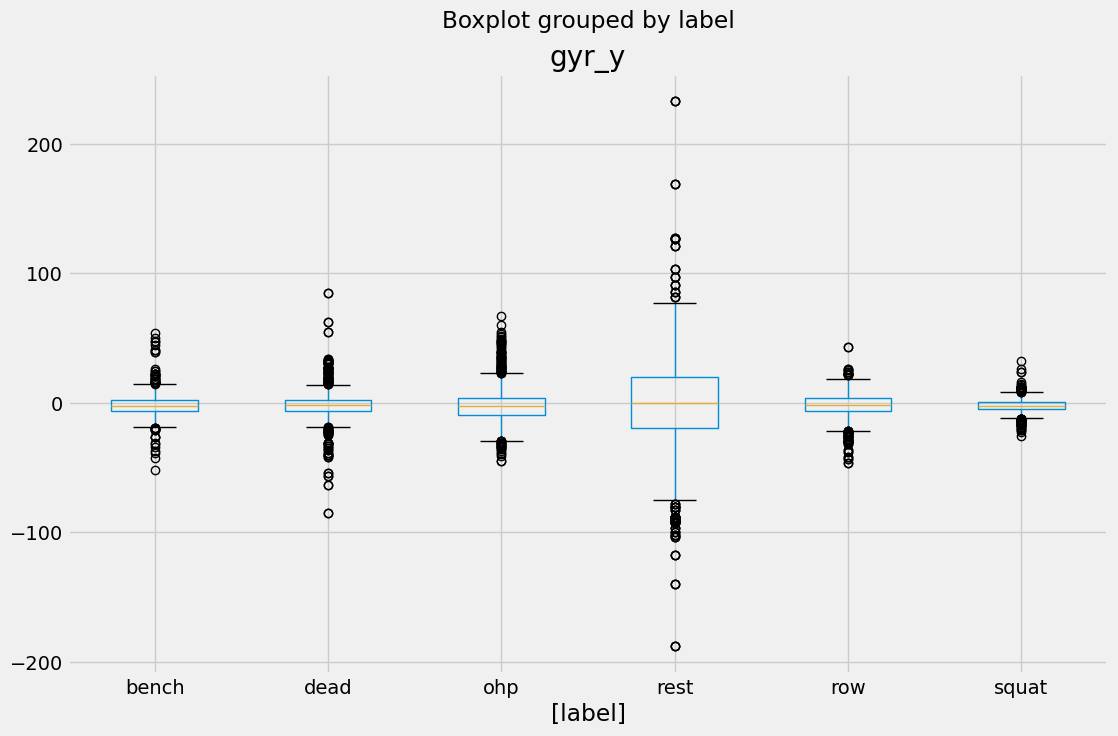

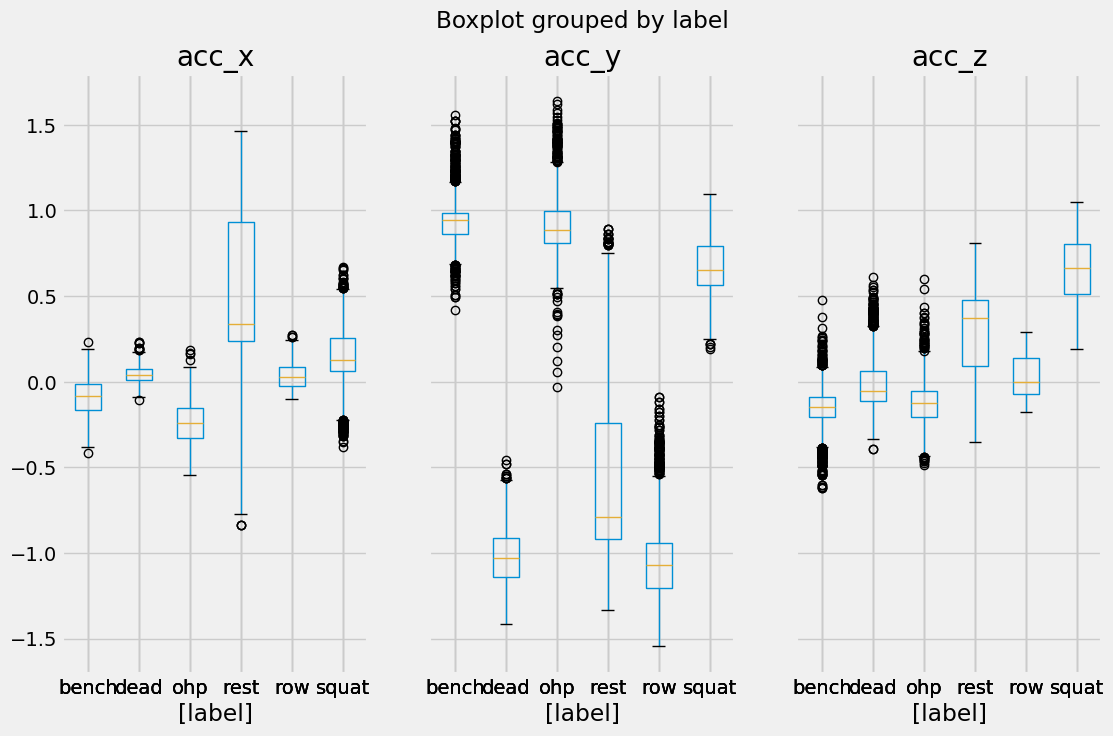

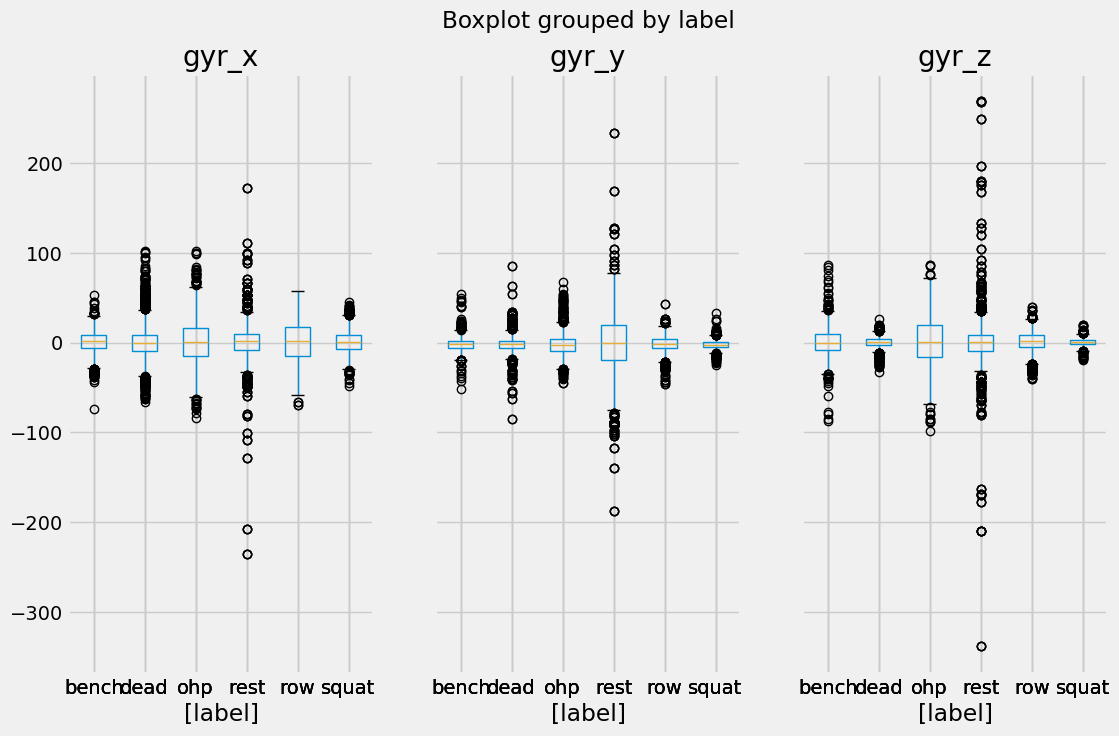

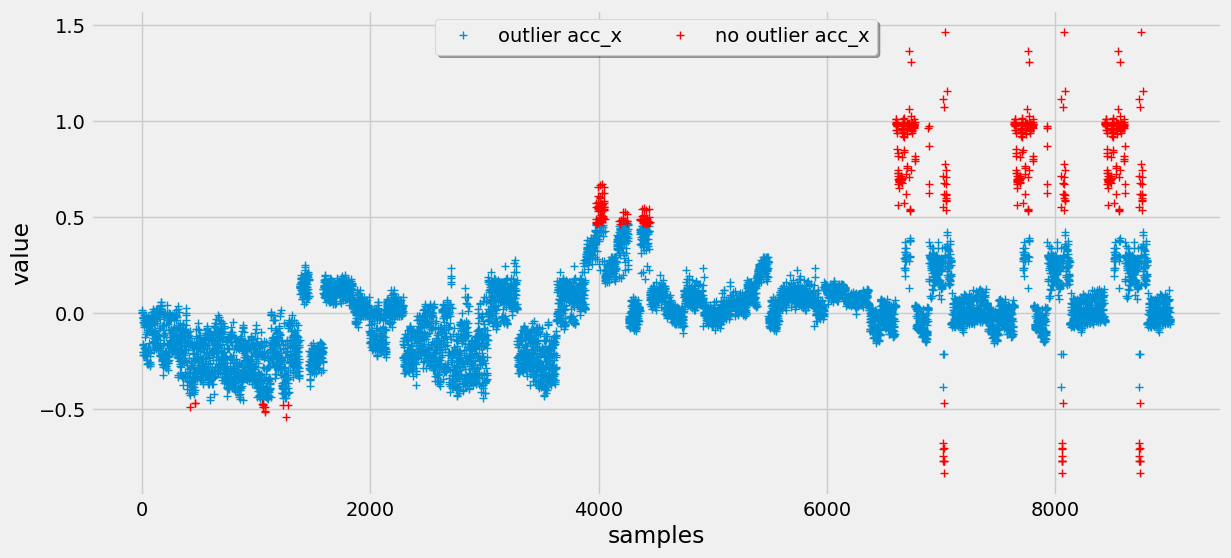

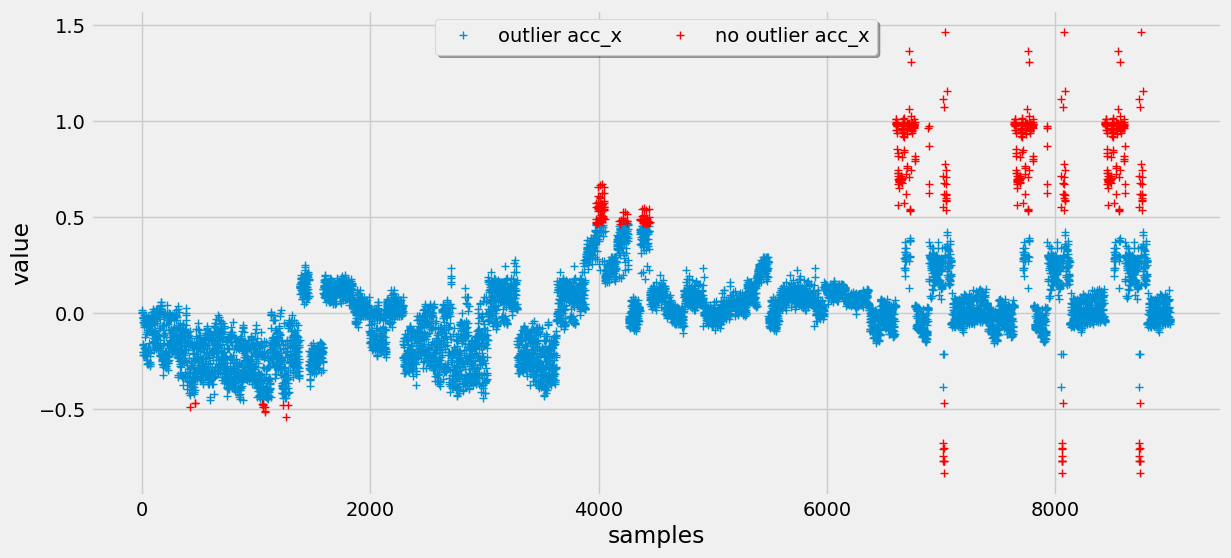

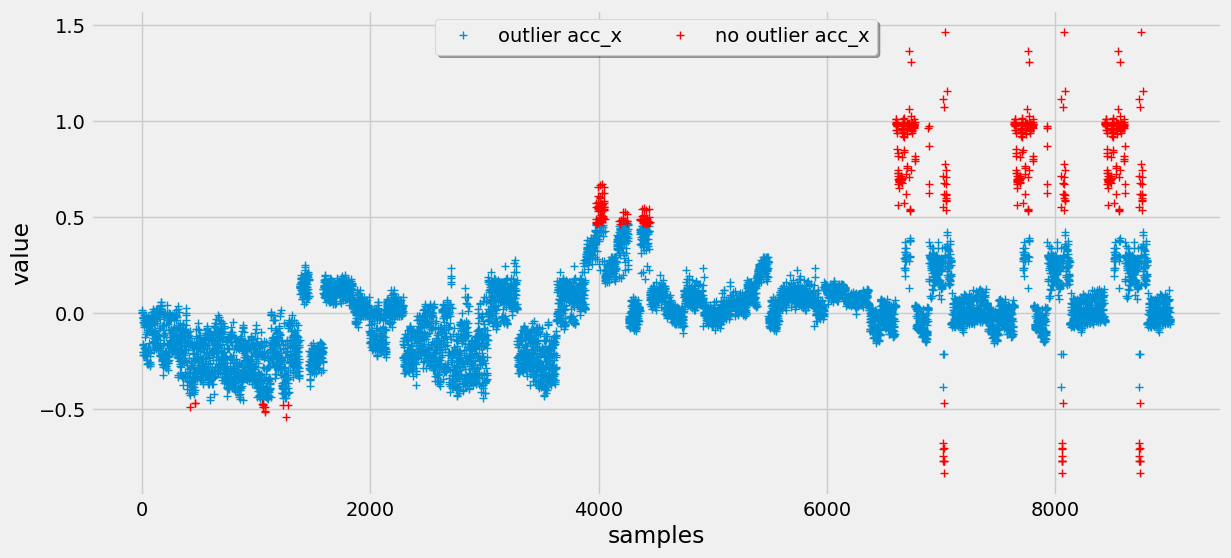

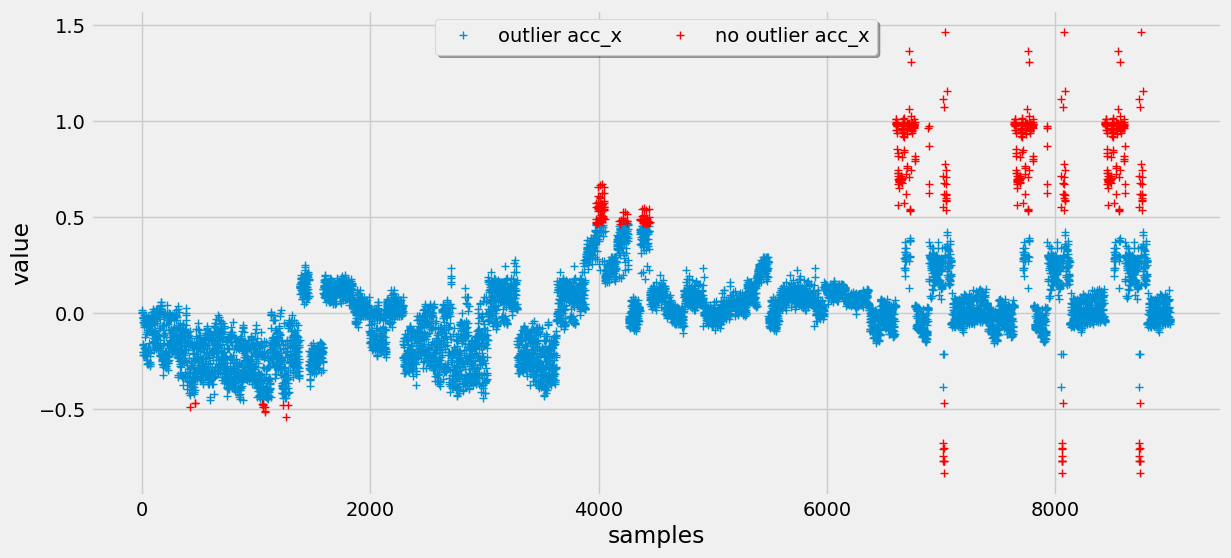

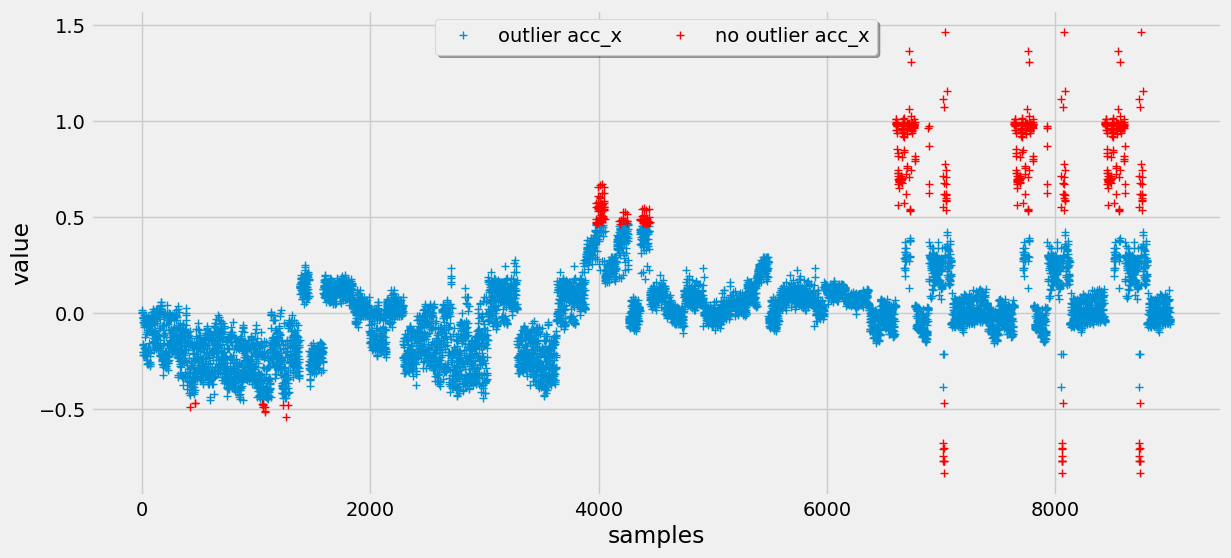

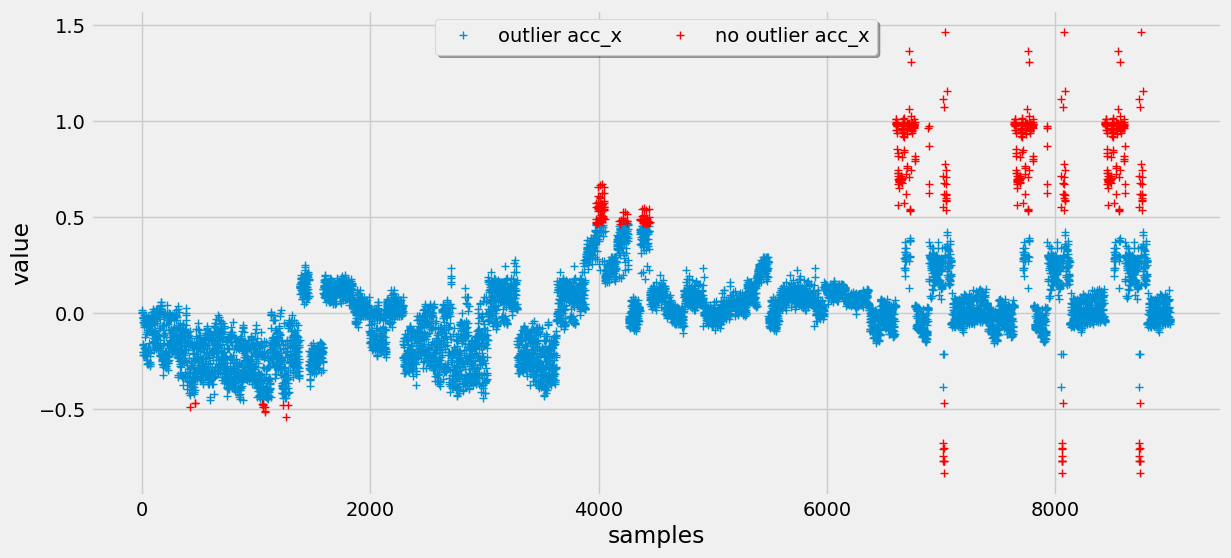

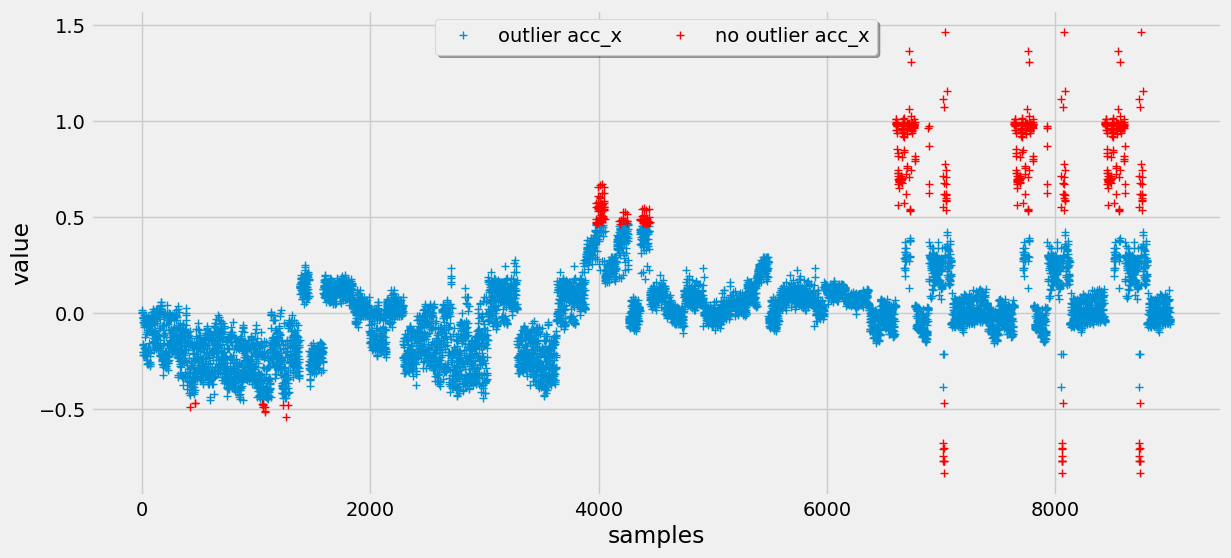

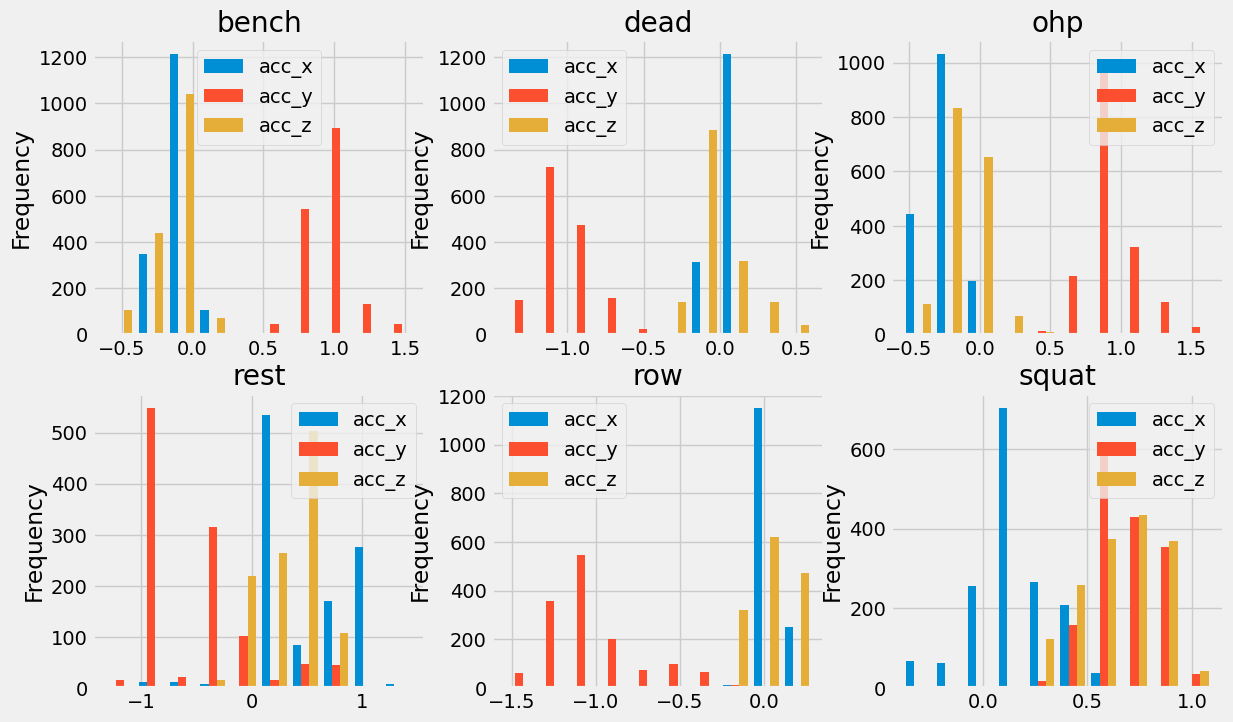

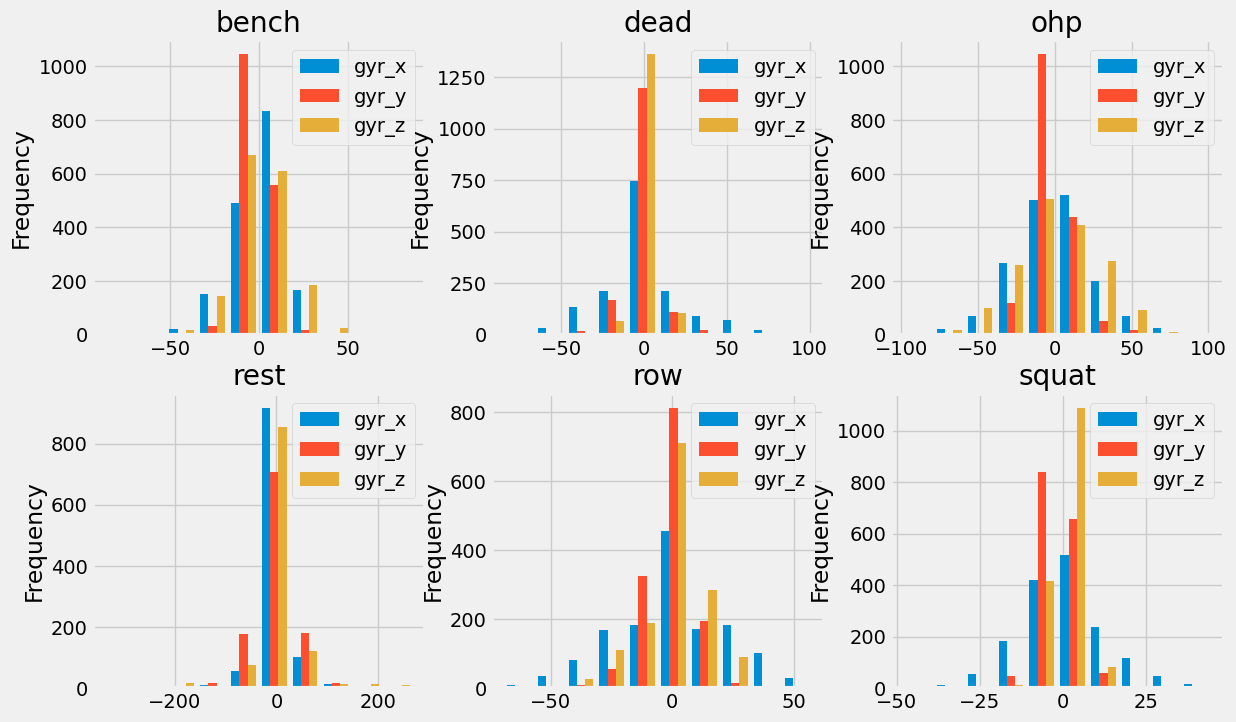

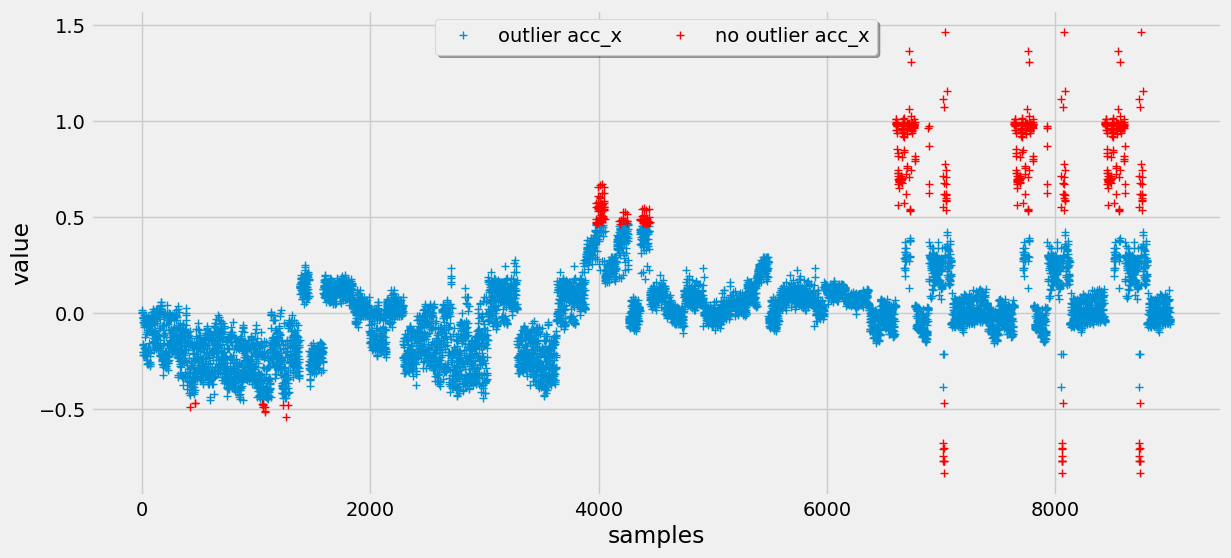

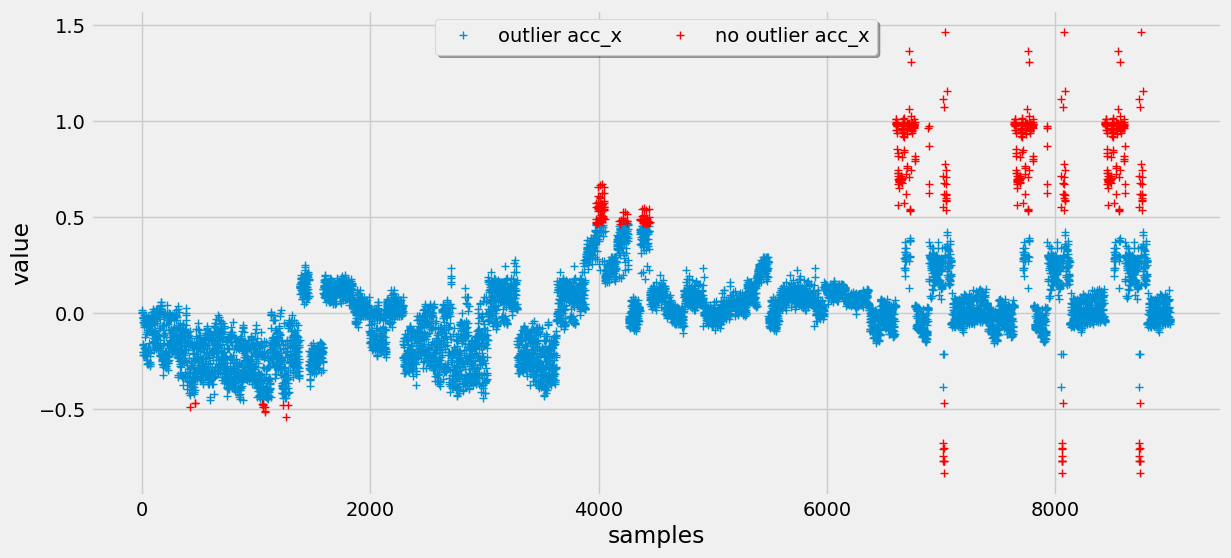

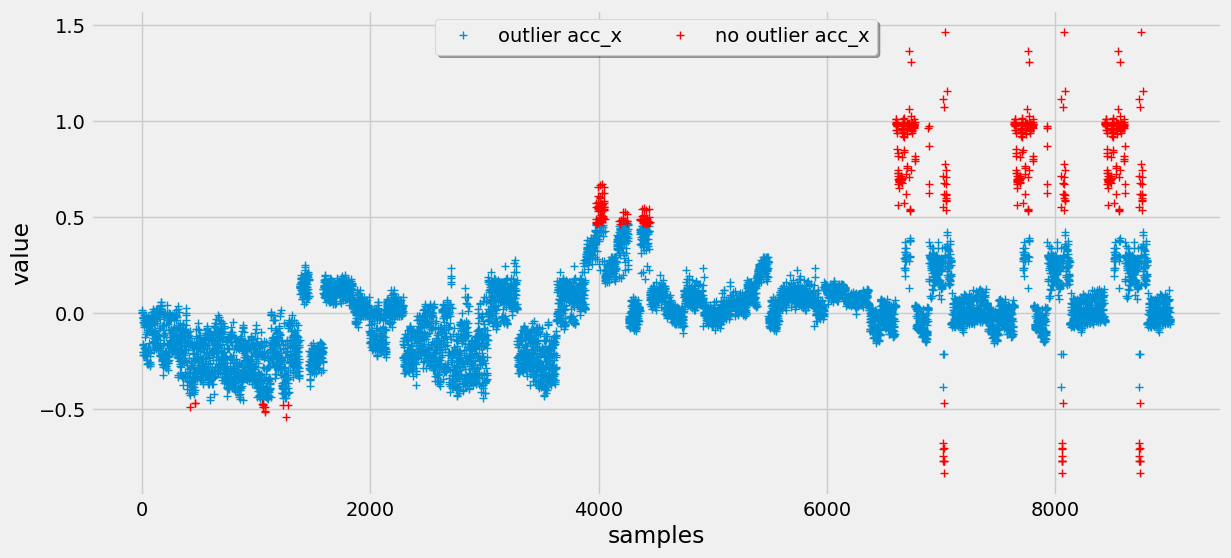

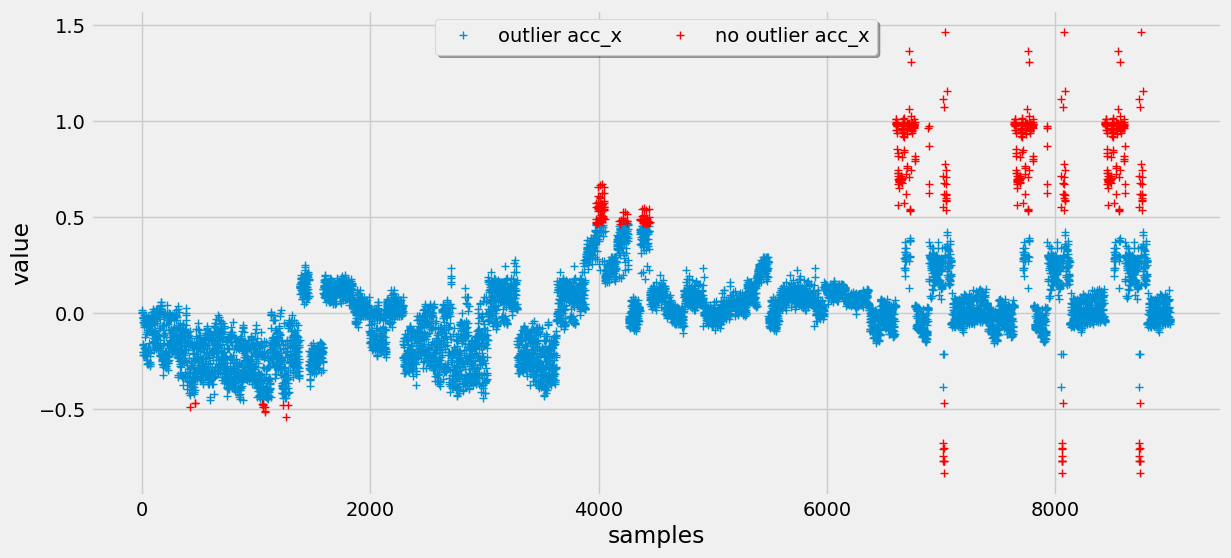

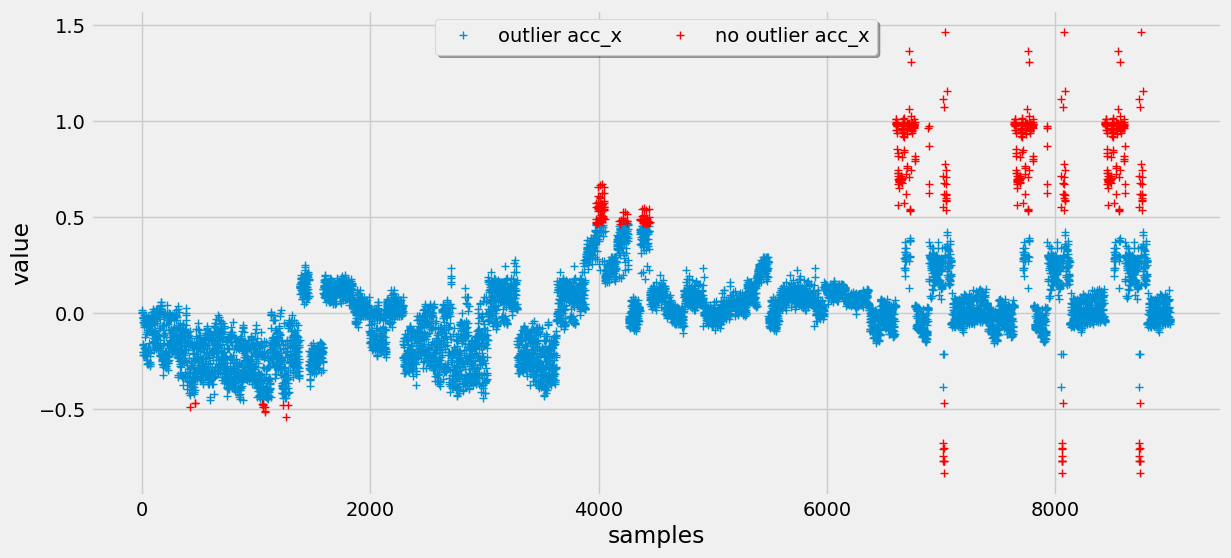

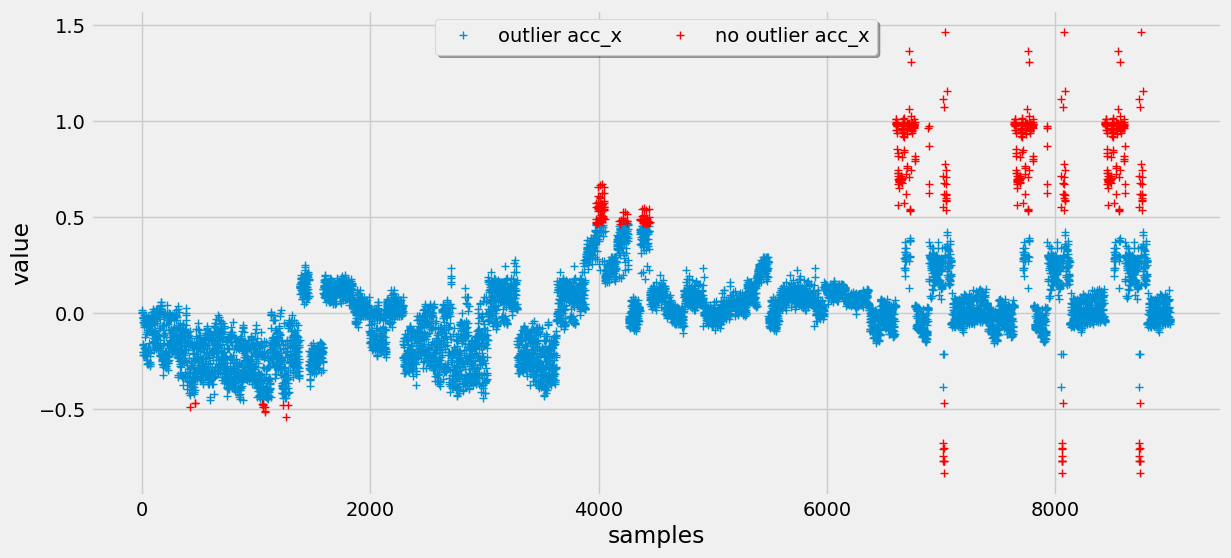

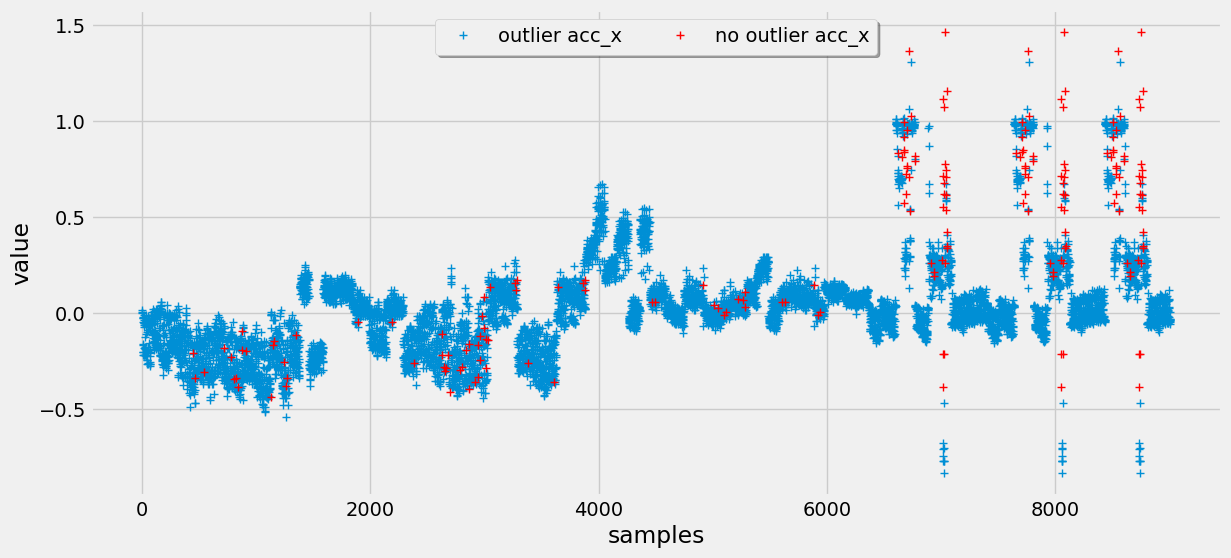

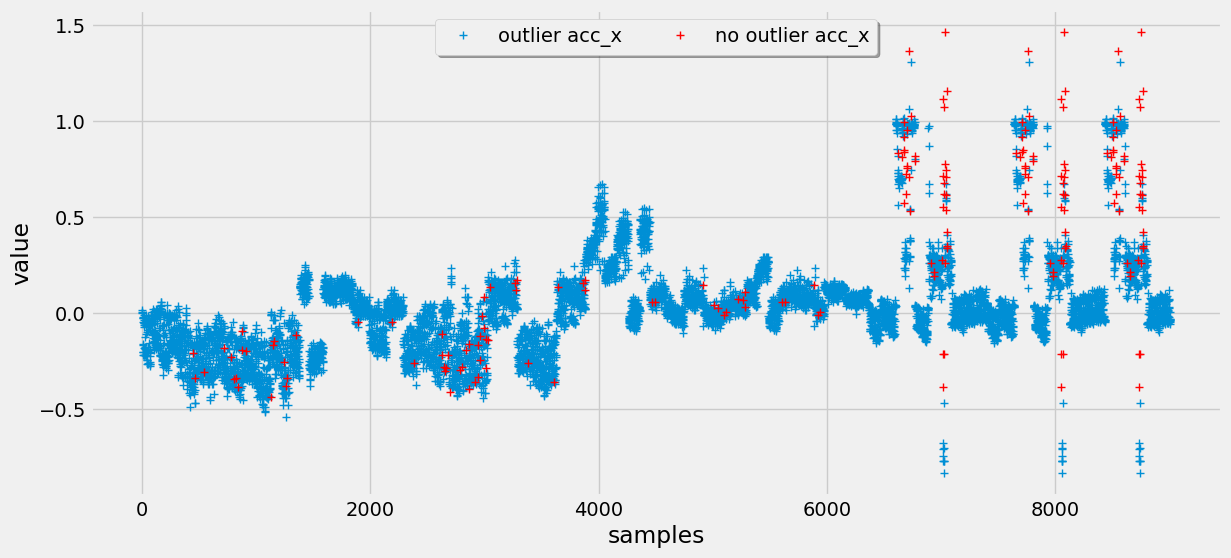

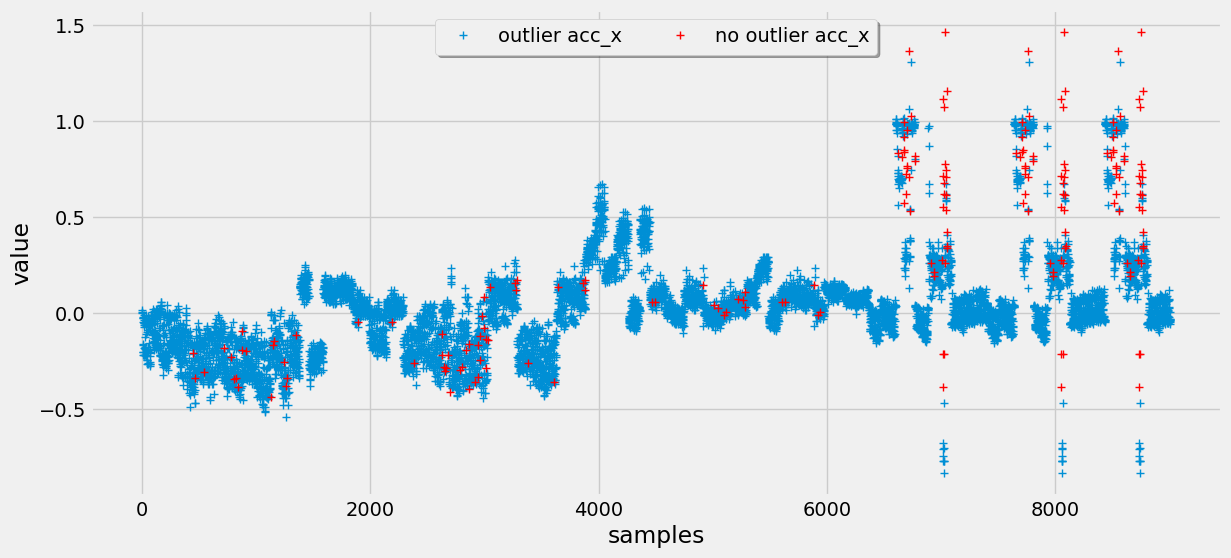

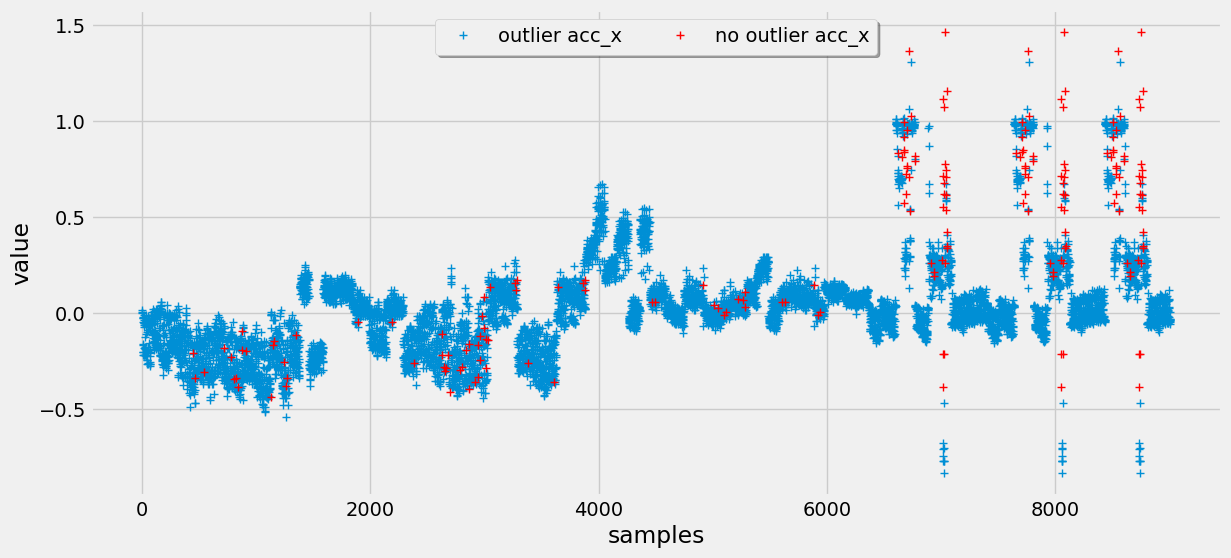

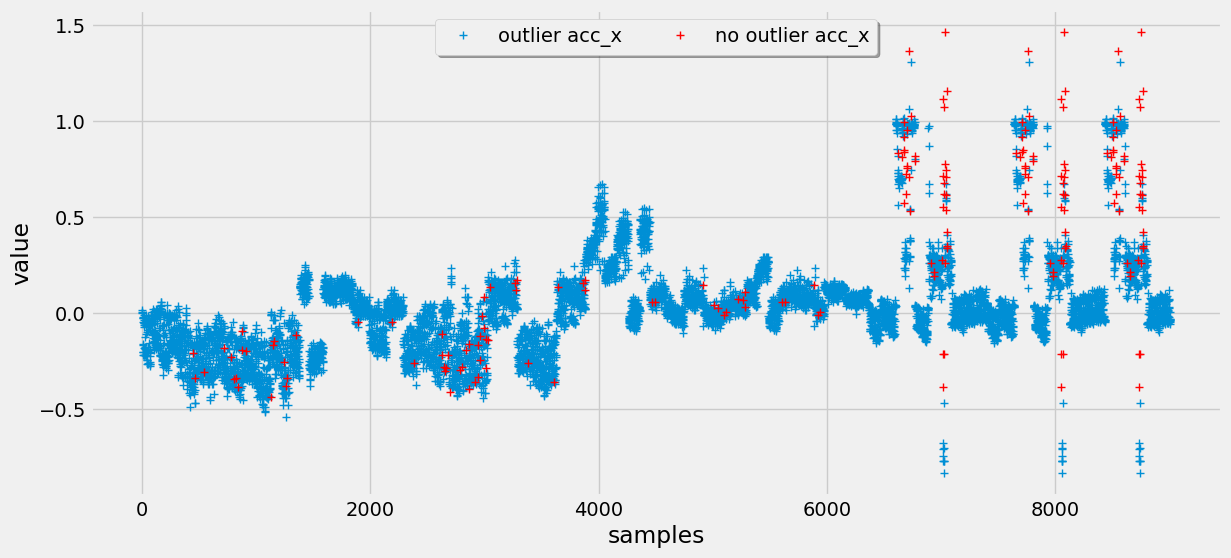

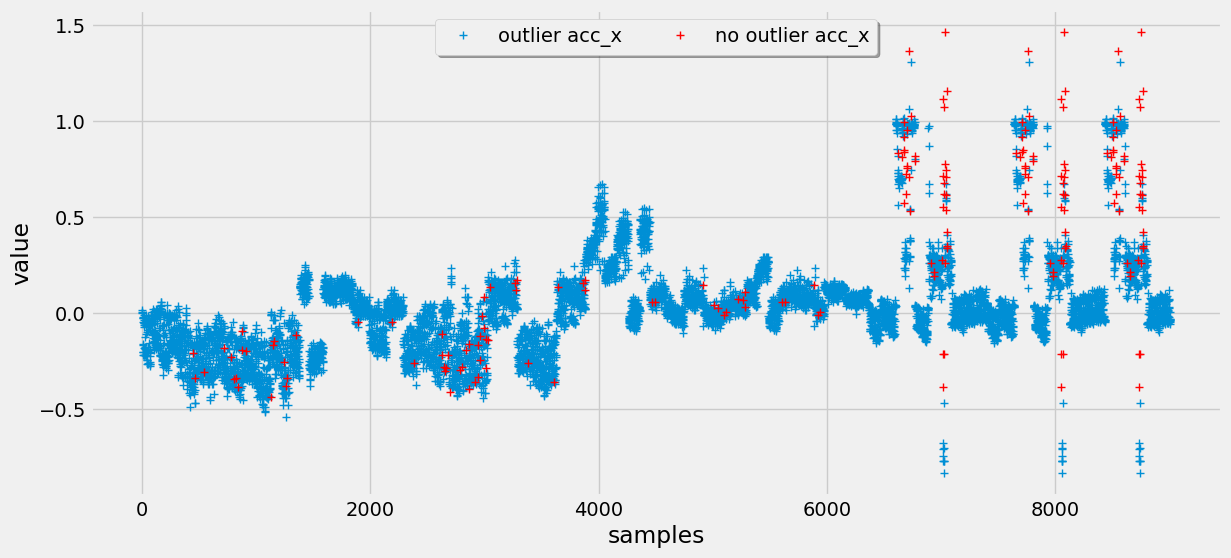

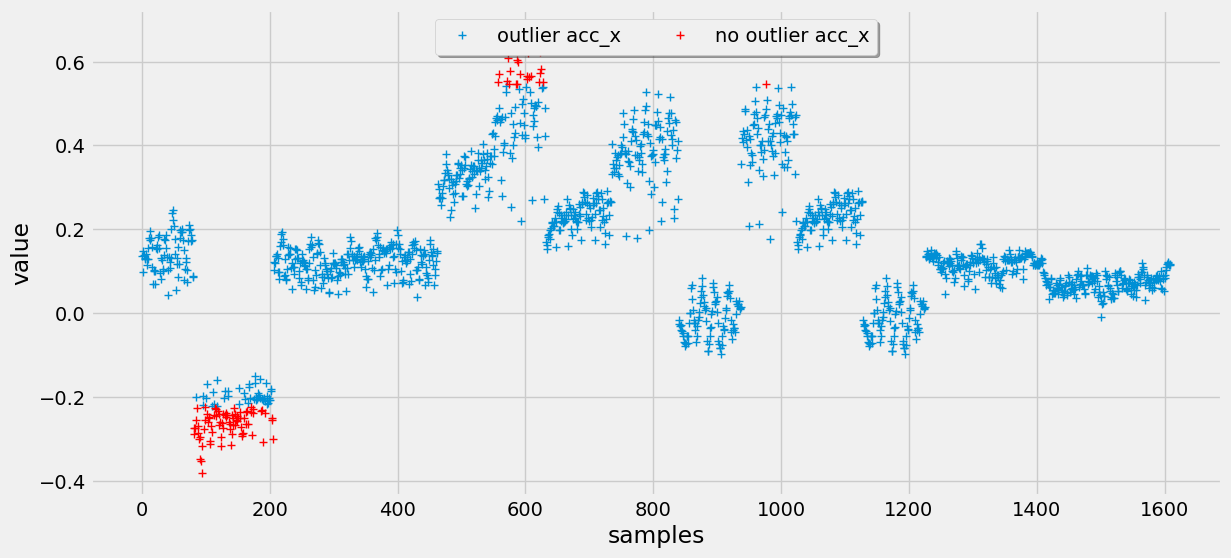

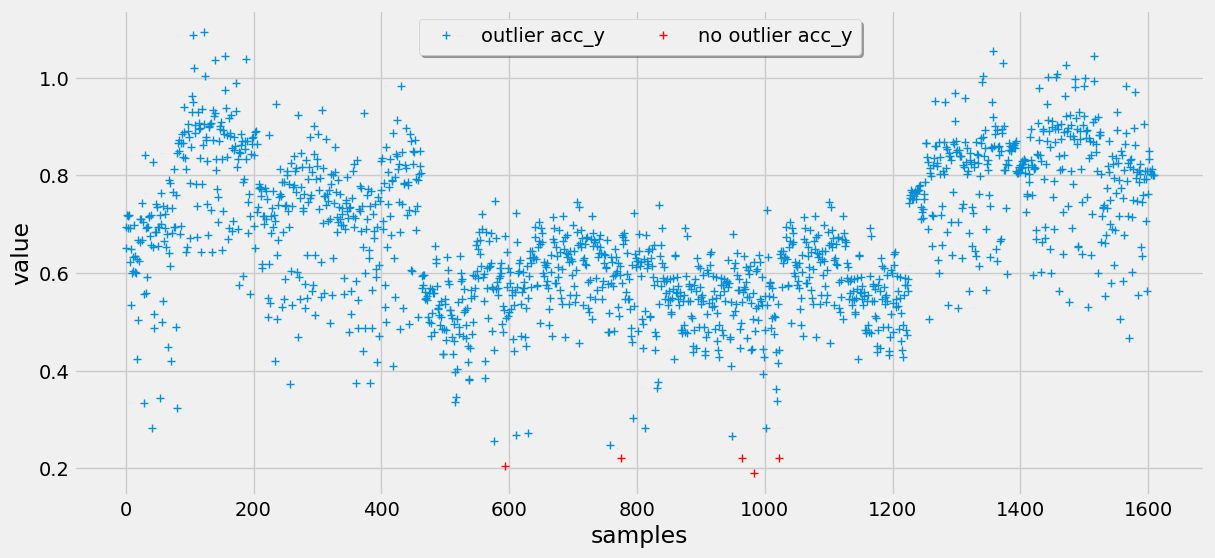

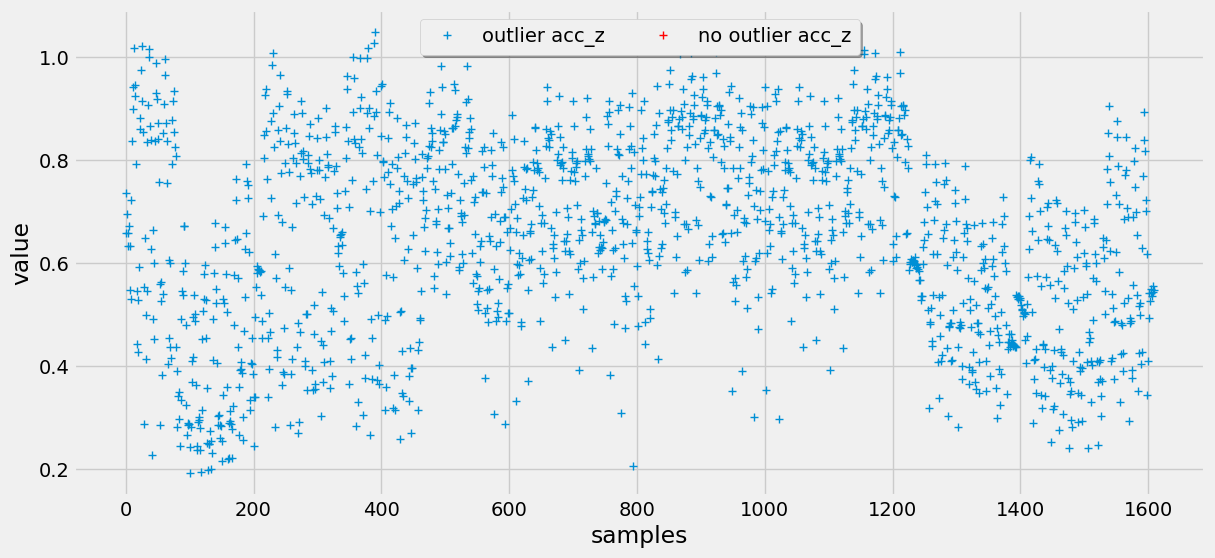

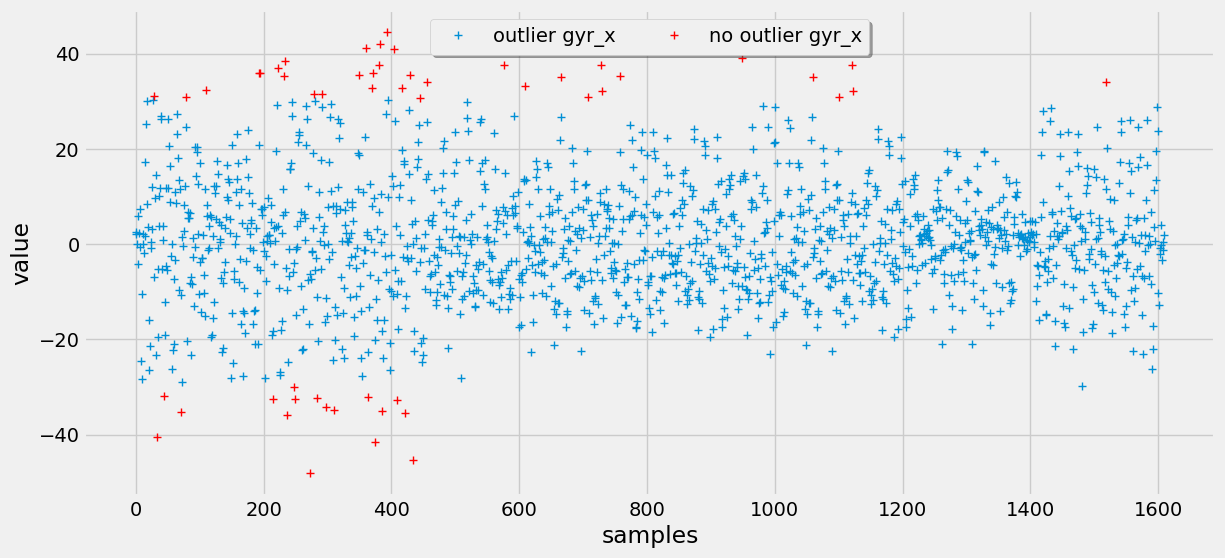

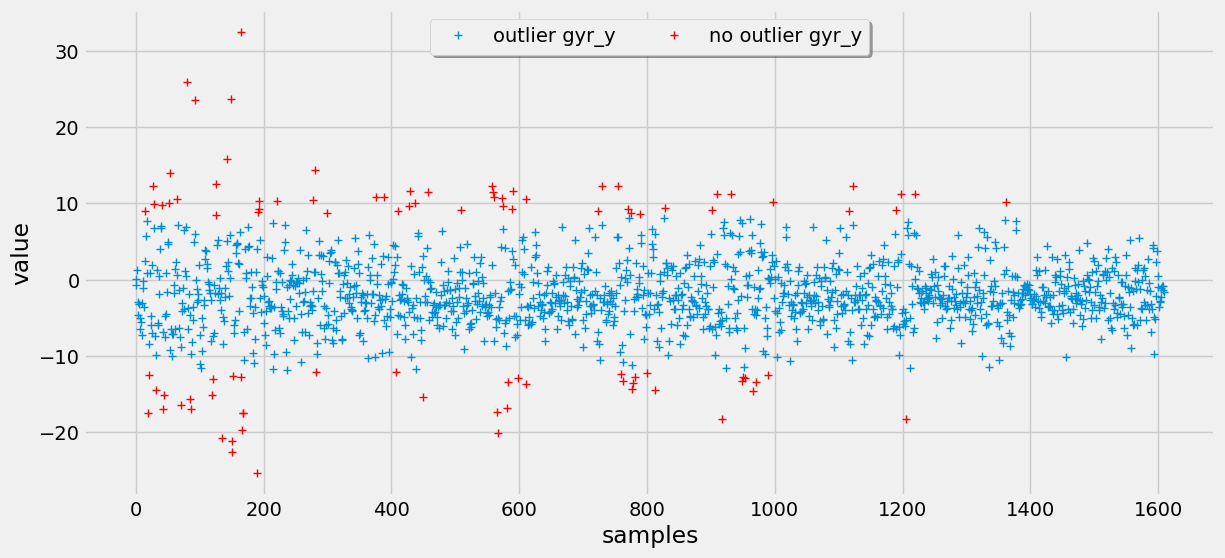

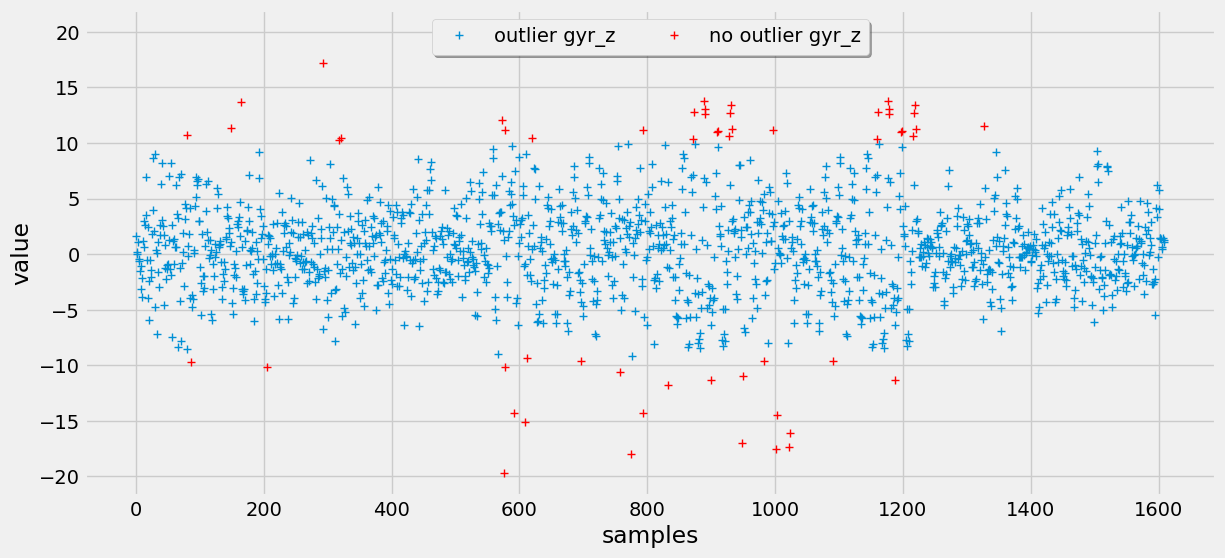

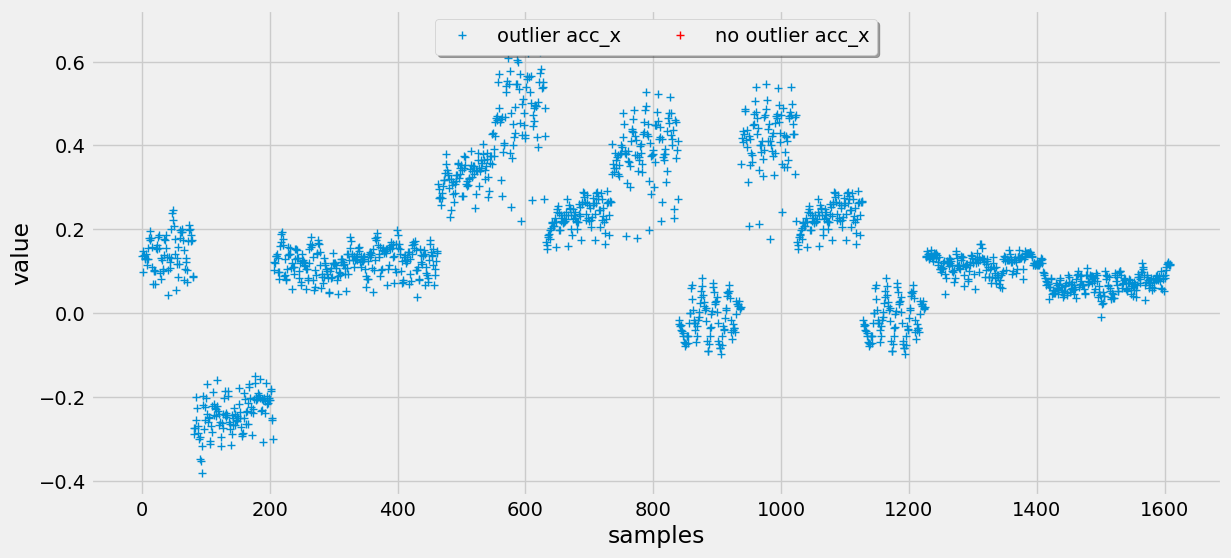

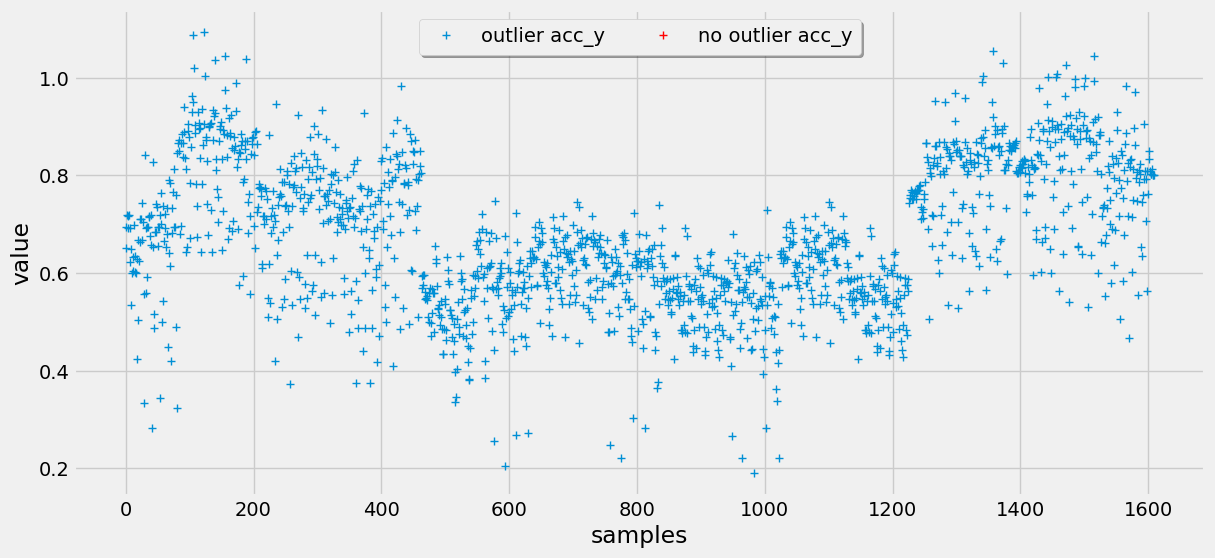

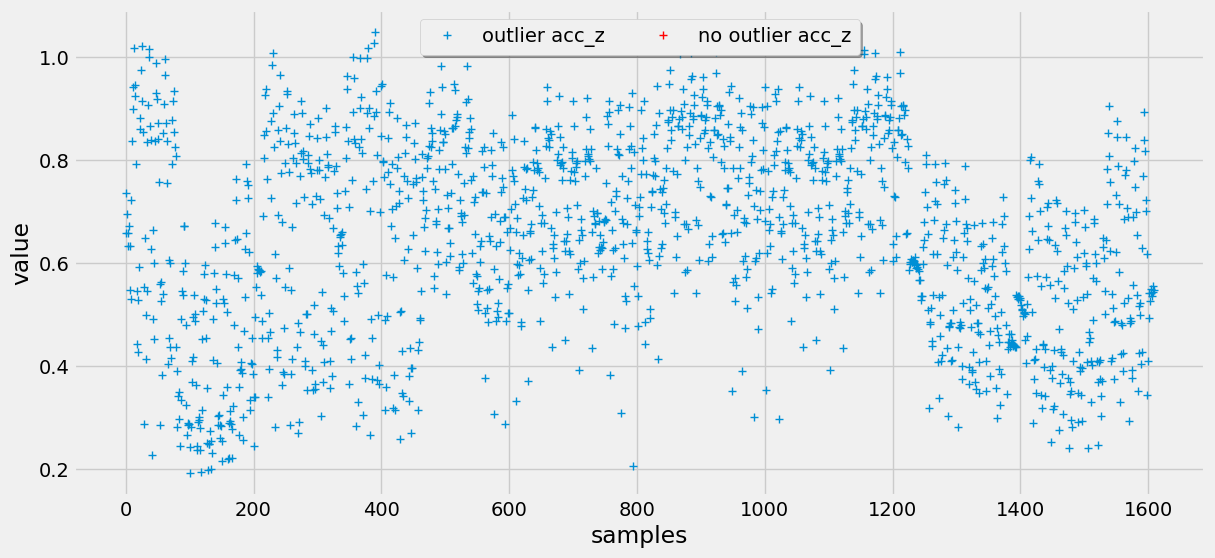

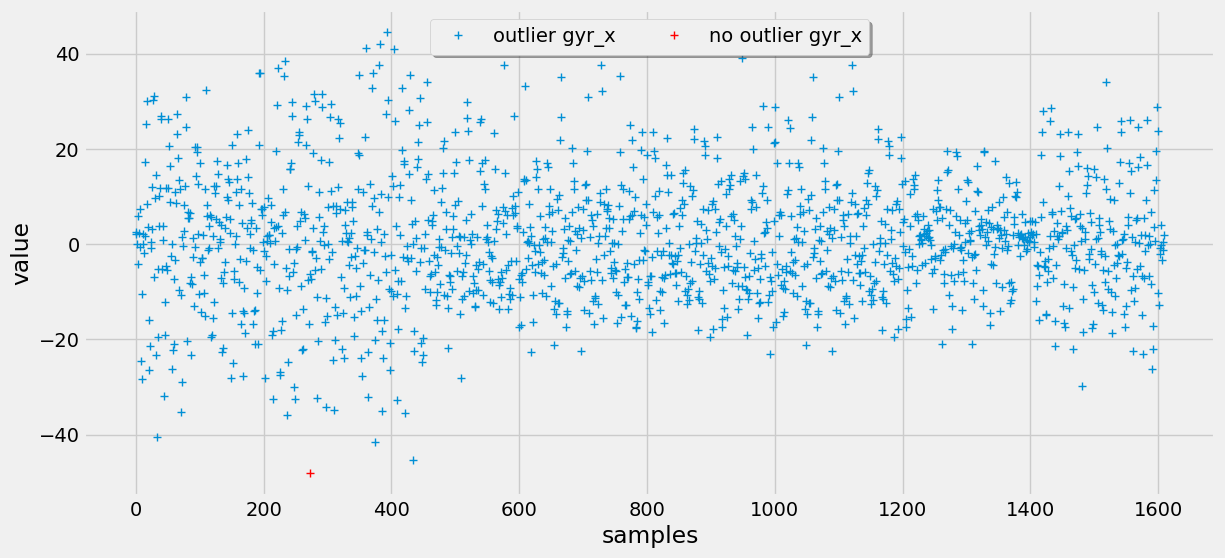

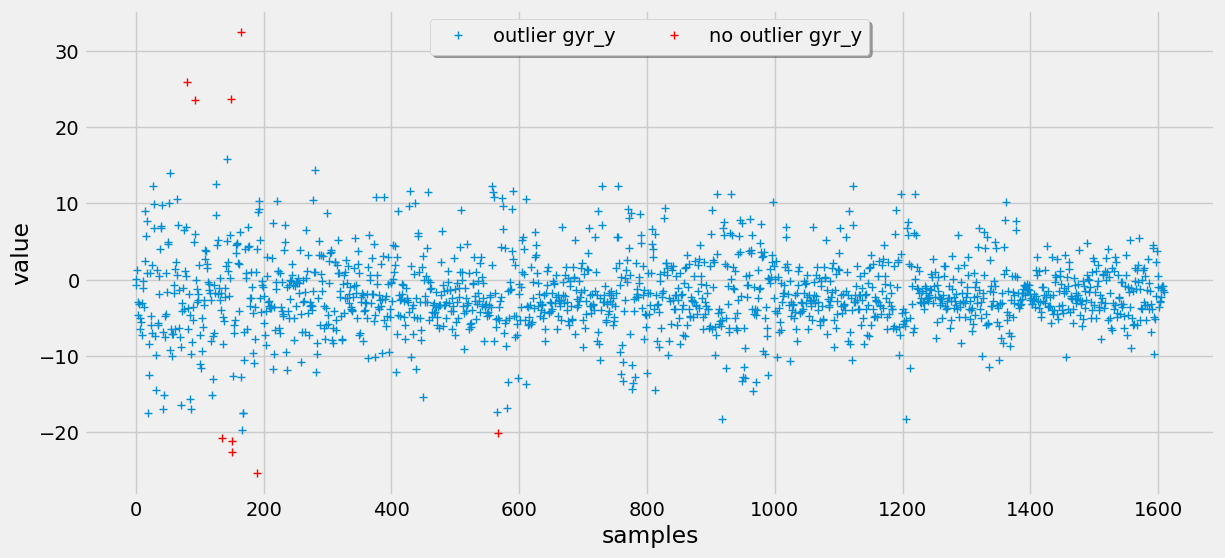

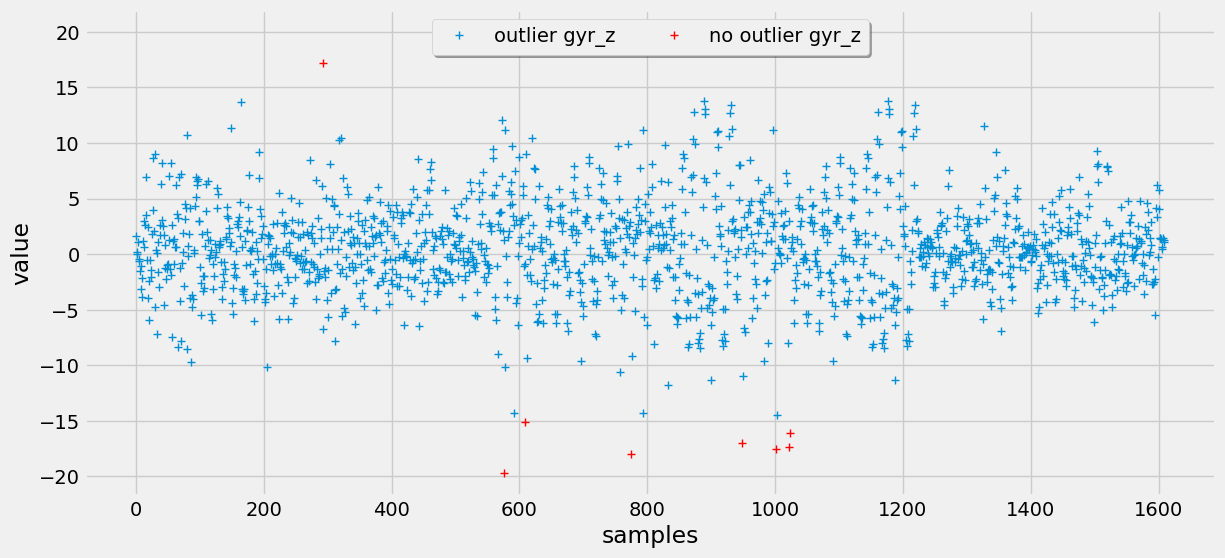

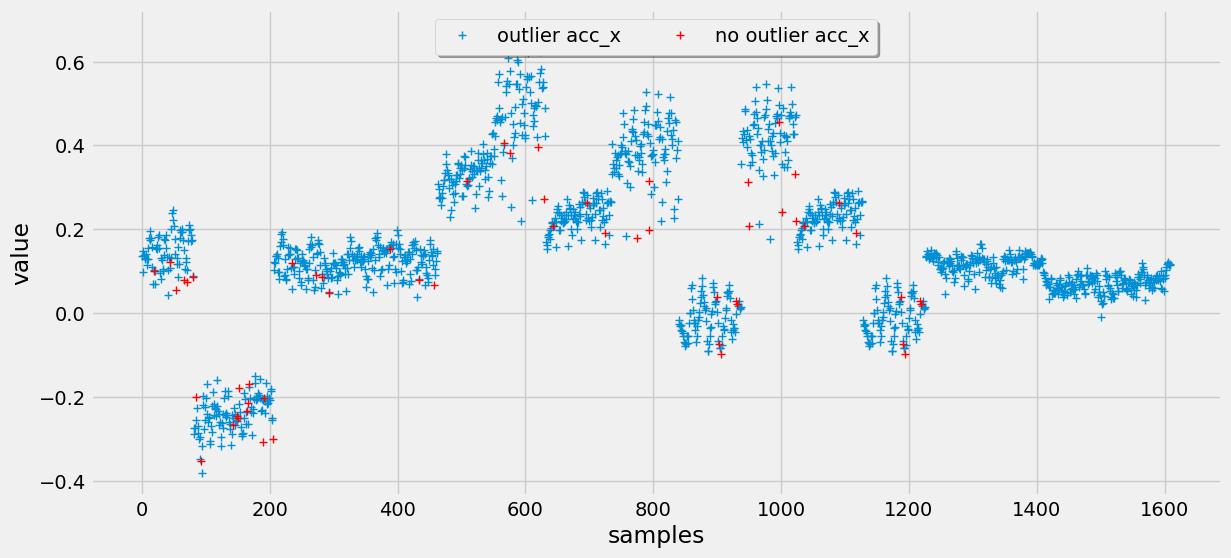

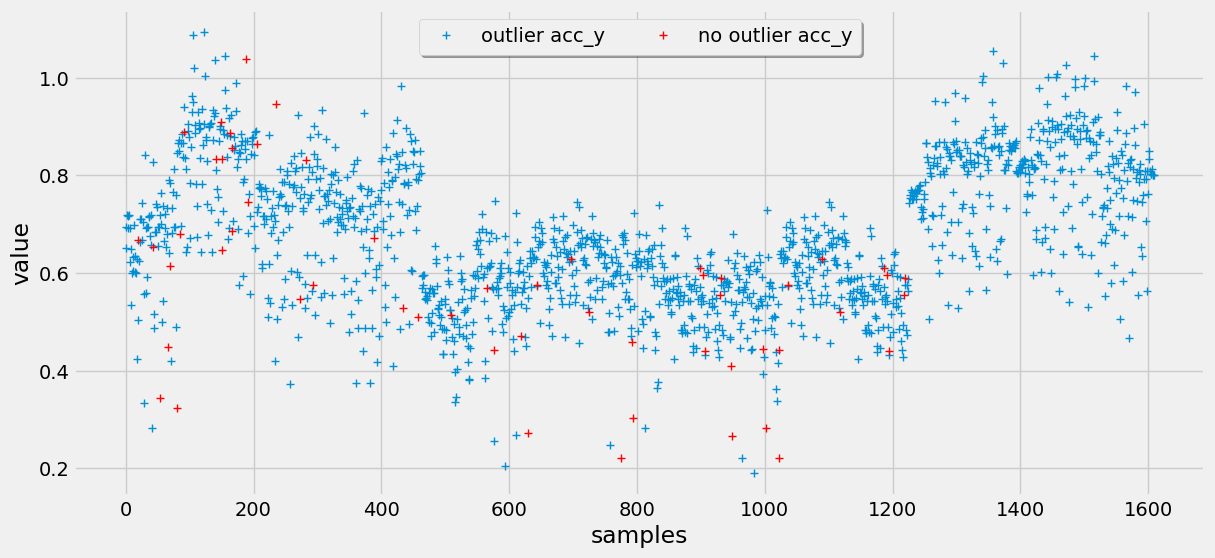

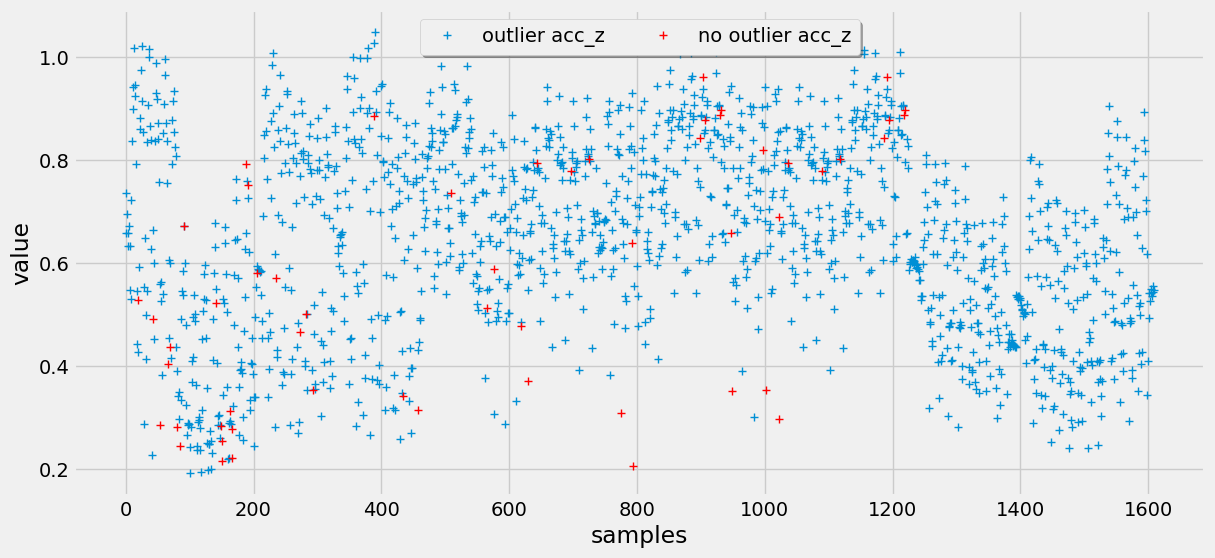

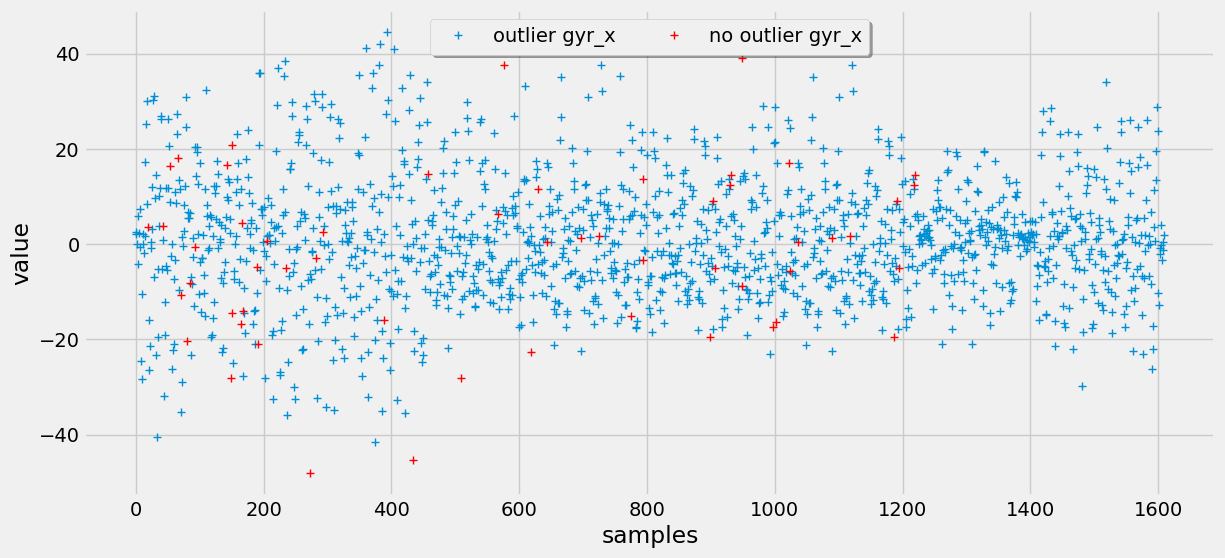

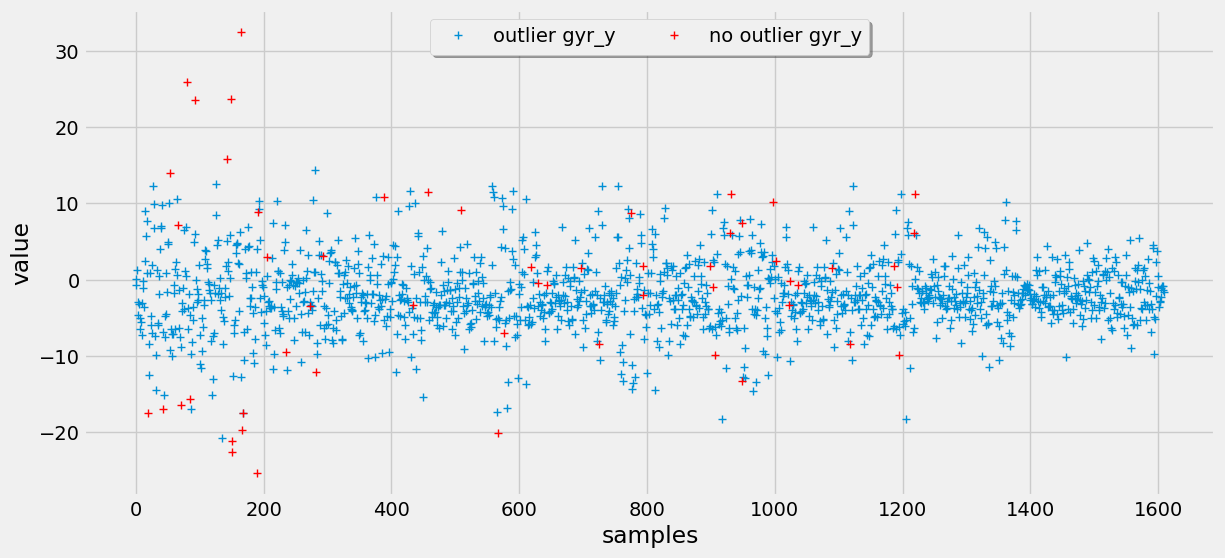

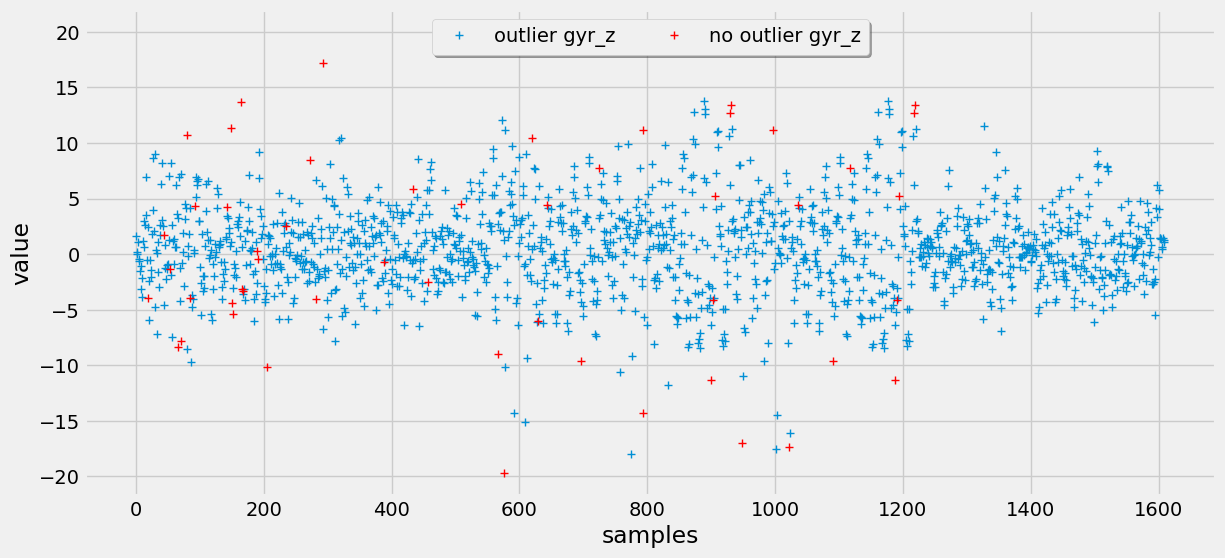

Removed 0 from acc_x for bench
Removed 2 from acc_x for ohp
Removed 0 from acc_x for squat
Removed 2 from acc_x for dead
Removed 0 from acc_x for row
Removed 0 from acc_x for rest
Removed 5 from acc_y for bench
Removed 6 from acc_y for ohp
Removed 0 from acc_y for squat
Removed 0 from acc_y for dead
Removed 0 from acc_y for row
Removed 0 from acc_y for rest
Removed 3 from acc_z for bench
Removed 6 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 1 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 2 from gyr_x for bench
Removed 4 from gyr_x for ohp
Removed 1 from gyr_x for squat
Removed 6 from gyr_x for dead
Removed 0 from gyr_x for row
Removed 12 from gyr_x for rest
Removed 14 from gyr_y for bench
Removed 15 from gyr_y for ohp
Removed 9 from gyr_y for squat
Removed 14 from gyr_y for dead
Removed 10 from gyr_y for row
Removed 9 from gyr_y for rest
Removed 13 from gyr_z for bench
Removed 1 from gyr_z for ohp
Removed 12 from gyr_z for squat
Re

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor  

# --------------------------------------------------------------
# Load data
# --------------------------------------------------------------
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")
outlier_colums = list(df.columns[:6])
# --------------------------------------------------------------
# Plotting outliers
# --------------------------------------------------------------
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (13,6)
plt.rcParams["figure.dpi"] = 100

df[["gyr_y", "label"]].boxplot(by="label", figsize = (13,8))
df[outlier_colums[:3]+ ["label"]].boxplot(by="label", figsize = (13,8), layout=(1,3))
df[outlier_colums[3:]+ ["label"]].boxplot(by="label", figsize = (13,8), layout=(1,3))
plt.show()

def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """


    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()
# --------------------------------------------------------------
# Interquartile range (distribution based)
# --------------------------------------------------------------

# Insert IQR function
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

# Plot a single column
col = "acc_x"
dataset = mark_outliers_iqr(df,col)
plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",reset_index=True)
# Loop over all columns
for column in outlier_colums : 
    dataset = mark_outliers_iqr(df,col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",reset_index=True)
    
# --------------------------------------------------------------
# Chauvenets criteron (distribution based)
# --------------------------------------------------------------

# Check for normal distribution
df[outlier_colums[:3]+ ["label"]].plot.hist(by="label", figsize = (13,8), layout=(2,3))
df[outlier_colums[3:]+ ["label"]].plot.hist(by="label", figsize = (13,8), layout=(2,3))
plt.show()
# Insert Chauvenet's function
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

# Loop over all columns
for column in outlier_colums : 
    dataset = mark_outliers_iqr(df,col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier",reset_index=True)

# --------------------------------------------------------------
# Local outlier factor (distance based)
# --------------------------------------------------------------

# Insert LOF function
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

# Loop over all columns

dataset, outliers, X_scores = mark_outliers_lof(df,outlier_colums)
for column in outlier_colums : 
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof",reset_index=True)

# --------------------------------------------------------------
# Check outliers grouped by label : phương pháo xử lý ngoại lệ 
# --------------------------------------------------------------
label = "squat"
for col in outlier_colums:
    dataset = mark_outliers_iqr(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col + "_outlier", reset_index=True)
    plt.show()

for col in outlier_colums:
    dataset = mark_outliers_chauvenet(df[df["label"] == label], col)
    plot_binary_outliers(dataset, col, col + "_outlier", reset_index=True)
    plt.show()

dataset, outliers, X_scores = mark_outliers_lof(df[df["label"] == label], outlier_colums)
for col in outlier_colums : 
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof",reset_index=True)
# --------------------------------------------------------------
# Choose method and deal with outliers
# --------------------------------------------------------------
# 1 chúng ta phải đưa ra lựa chọn sử dụng phương pháp nào 
col = "gyr_z"
dataset = mark_outliers_chauvenet(df, col=col)
dataset[dataset["gyr_z_outlier"]]
dataset.loc[dataset["gyr_z_outlier"], "gyr_z"] = np.nan

# Test on single column
outliers_remove_df = df.copy()
for col in outlier_colums:
    for label in df["label"].unique():
         dataset = mark_outliers_chauvenet(df[df["label"] == label], col)

         #Replace values marked as outliers with NaN
         dataset.loc[dataset[col+"_outlier"], col] = np.nan
         #update the column in the original dataframe 
         outliers_remove_df.loc[(outliers_remove_df["label"] == label), col] = dataset[col]
         n_outliers = len(dataset) - len(dataset[col].dropna())
         print(f"Removed {n_outliers} from {col} for {label}")

outliers_remove_df.info()
# Create a loop

# --------------------------------------------------------------
# Export new dataframe
# --------------------------------------------------------------
outliers_remove_df.to_pickle("../../data/interim/02_outlier_removed_chauvenets.pkl")